In [1]:
import os
import ot
import json
import pprint
import networkx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from utils.preprocessing import feature_scaling
from utils.preprocessing import feature_normalization
from utils.plot import generate_hierarchical_graph_json
from utils.plot import generate_links_json

from domain_adaptation import compute_mass_flow
from domain_adaptation import undesired_mass_flow_index

plt.rcParams['mathtext.fontset'] = 'custom'  
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'  
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'  
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'  
plt.rcParams['font.size'] = 16  
plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['font.family'] = 'STIXGeneral' 

plt.style.use('science')

palette = [
    'royalblue',
    'firebrick',
    'darkgoldenrod',
    'darkseagreen',
    'grey',
    'darkslategray',
    'crimson',
    'midnightblue',
    'saddlebrown',
    'orange',
    'seagreen',
    'dodgerblue',
    'black'
]

Using TensorFlow backend.


In [2]:
data_mat = np.load('./data/cstr_rawdata.npy')
X = data_mat[:, :-4]
y = data_mat[:, -4]
d = data_mat[:, -3]

domain = 1
Xs, ys = X[np.where(d == 0)[0]], y[np.where(d == 0)[0]]

In [10]:
for domain in np.unique(d)[1:]:
    print("Starting calculations for Domain {}".format(domain))
    Xt, yt = X[np.where(d == domain)[0]], y[np.where(d == domain)[0]]
    all_y = np.concatenate([ys, yt])
    custom_order_index = np.concatenate([
        np.where(all_y == i)[0] for i in range(13)
    ])

    ns = Xs.shape[0]
    nt = Xt.shape[0]

    a = ot.unif(ns)
    b = ot.unif(nt)
    M = ot.dist(feature_normalization(Xs), feature_normalization(Xt), metric='cityblock')
    M = M / np.max(M)
    Gemd = ot.emd(a, b, M)

    Aemd = np.zeros([ns + nt, ns + nt])
    Gmax = np.max(Gemd)
    Gmin = np.min(Gemd)

    for i in range(ns):
        for j in range(nt):
            if Gemd[i, j] > 0.0:
                Aemd[i, ns + j] = Gemd[i, j]
                Aemd[ns + j, i] = Gemd[i, j]

    nodes = ['Src{}'.format(i) for i in range(ns)] + ['Tgt{}'.format(j) for j in range(nt)]
    faults = []
    for yi in np.concatenate([ys, yt], axis=0):
        if yi != 12:
            faults.append('Fault{}'.format(int(yi)))
        else:
            faults.append('NormalOperation')
    hierarchical_graph = generate_hierarchical_graph_json(nodes, faults, Aemd)
    links = generate_links_json(nodes, faults, Aemd)

    with open('./results/HierarchicalGraph_EMD_Target{}.json'.format(domain), 'w') as f:
        f.write(json.dumps(hierarchical_graph))

    with open('./results/Links_EMD_Target{}.json'.format(domain), 'w') as f:
        f.write(json.dumps(links))

Starting calculations for Domain 1.0
Starting calculations for Domain 2.0
Starting calculations for Domain 3.0
Starting calculations for Domain 4.0
Starting calculations for Domain 5.0
Starting calculations for Domain 6.0


## Distributional Shift vs. Undesired Mass Flow

In [2]:
data_mat = np.load('./data/cstr_rawdata.npy')
X = data_mat[:, :-4]
y = data_mat[:, -4]
d = data_mat[:, -3]

In [3]:
umf_emd = []
umf_sink = []
wdists_emd = []
wdists_sink = []

for domain in np.unique(d)[1:]:
    Xs, ys = X[np.where(d == 0)[0]], y[np.where(d == 0)[0]]
    Xt, yt = X[np.where(d == domain)[0]], y[np.where(d == domain)[0]]

    ns = Xs.shape[0]
    nt = Xt.shape[0]

    a = ot.unif(ns)
    b = ot.unif(nt)
    M = ot.dist(feature_normalization(Xs),
                feature_normalization(Xt),
                metric='cityblock')
    M = M / np.max(M)
    Gemd = ot.emd(a, b, M)
    Gsink = ot.sinkhorn(a, b, M, reg=1e-2)
    
    wdists_emd.append(np.sum(M * Gemd))
    wdists_sink.append(np.sum(M * Gsink))
    umf_emd.append(undesired_mass_flow_index(Gemd, ys, yt))
    umf_sink.append(undesired_mass_flow_index(Gsink, ys, yt))

(0.0, 0.46)

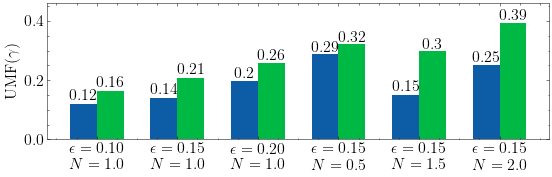

In [4]:
fig, ax = plt.subplots(figsize=(9, 2.5))

bar_pos1 = np.arange(6) * 3
bar_pos2 = np.arange(6) * 3 + 1
ax.bar(bar_pos1, umf_emd, width=1)
ax.bar(bar_pos2, umf_sink, width=1)

for pos, umf in zip(bar_pos1, umf_emd):
    ax.text(pos, umf + 1e-2, s="{}".format(np.round(umf, 2)), ha='center')
for pos, umf in zip(bar_pos2, umf_sink):
    ax.text(pos, umf + 1e-2, s="{}".format(np.round(umf, 2)), ha='center')

ax.set_ylabel('UMF$(\gamma)$')
ax.set_xticks(.5 * (bar_pos1 + bar_pos2))
ax.set_xticklabels([r'$\epsilon=0.10$' + '\n' + r'$N = 1.0$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 1.0$',
                    r'$\epsilon=0.20$' + '\n' + r'$N = 1.0$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 0.5$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 1.5$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 2.0$'])
ax.set_ylim([0.0, 0.46])

# plt.savefig('./Figures/Ch6/UndesiredMassFlow.pdf')

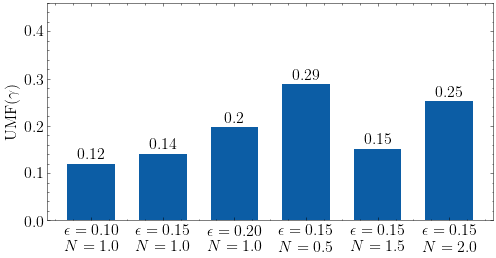

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

bar_pos1 = np.arange(6) * 3
ax.bar(bar_pos1, umf_emd, width=2)

for pos, umf in zip(bar_pos1, umf_emd):
    ax.text(pos, umf + 1e-2, s="{}".format(np.round(umf, 2)), ha='center')

ax.set_ylabel('UMF$(\gamma)$')
ax.set_xticks(bar_pos1)
ax.set_xticklabels([r'$\epsilon=0.10$' + '\n' + r'$N = 1.0$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 1.0$',
                    r'$\epsilon=0.20$' + '\n' + r'$N = 1.0$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 0.5$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 1.5$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 2.0$'])
ax.set_ylim([0.0, 0.46])

plt.savefig('./Figures/Presentation/UndesiredMassFlow.pdf')

## Classification Performance vs. UMF

In [2]:
data_mat = np.load('./data/cstr_rawdata.npy')
X = data_mat[:, :-4]
y = data_mat[:, -4]
d = data_mat[:, -3]

Xs, ys = X[np.where(d == 0)[0]], y[np.where(d == 0)[0]]

dataset = np.load('./data/DistributionalShiftData/raw_cstr_distrshift.npy')

X = dataset[:, :-3]
y = dataset[:, -3]
E = dataset[:, -2]
N = dataset[:, -1]

targets_E = [
    (eps,
     X[np.intersect1d(np.where(E == eps)[0], np.where(N == 1))],
     y[np.intersect1d(np.where(E == eps)[0], np.where(N == 1))]) for eps in [i / 10 for i in range(1, 10)]
]

targets_N = [
    (Ni,
     X[np.intersect1d(np.where(E == 0.15)[0], np.where(N == Ni))],
     y[np.intersect1d(np.where(E == 0.15)[0], np.where(N == Ni))]) for Ni in [0.25, 0.5, 0.75, 1,
                                                                              1.25, 1.75, 2.0]
]

In [4]:
umf_emd = []
emd_acc = []
umf_sink = []
sink_acc = []
clf = SVC(kernel='linear', max_iter=1e+6)

emd = ot.da.EMDTransport(norm='max')
sink = ot.da.SinkhornTransport(reg_e=1e-3, norm='max')
for param, Xt, yt in targets_E + targets_N:
    Xtr = feature_normalization(Xs)
    Xts = feature_normalization(Xt)
    
    emd.fit(Xs=Xtr, Xt=Xts)
    sink.fit(Xs=Xtr, Xt=Xts)
    
    Gemd = emd.coupling_
    Gsink = sink.coupling_
    
    umf_emd.append(undesired_mass_flow_index(Gemd, ys, yt))
    umf_sink.append(undesired_mass_flow_index(Gsink, ys, yt))
    
    TXtr = emd.transform(Xtr)
    clf.fit(TXtr, ys)
    yp = clf.predict(Xts)
    emd_acc.append(accuracy_score(yt, yp))
    
    TXtr = sink.transform(Xtr)
    clf.fit(TXtr, ys)
    yp = clf.predict(Xts)
    sink_acc.append(accuracy_score(yt, yp))

/home/eduardo/.conda/envs/OptimalTransport/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [8]:
umf_emd = []
emd_acc = []
umf_sink = []
sink_acc = []
clf = SVC(kernel='linear', max_iter=1e+6)

for param, Xt, yt in targets_E + targets_N:
    Xtr = feature_normalization(Xs)
    Xts = feature_normalization(Xt)

    ns = Xs.shape[0]
    nt = Xt.shape[0]

    a = ot.unif(ns)
    b = ot.unif(nt)
    M = ot.dist(Xtr, Xts, metric='cityblock')
    M = M / np.max(M)
    Gemd = ot.emd(a, b, M)
    Gsink = ot.sinkhorn(a, b, M, reg=1e-3)
    
    umf_emd.append(undesired_mass_flow_index(Gemd, ys, yt))
    umf_sink.append(undesired_mass_flow_index(Gsink, ys, yt))
    
    TXtr = ns * np.dot(Gemd, Xts)
    clf.fit(TXtr, ys)
    yp = clf.predict(Xts)
    emd_acc.append(accuracy_score(yt, yp))
    print(param, emd_acc[-1], umf_emd[-1])
    
    TXtr = ns * np.dot(Gsink, Xts)
    clf.fit(TXtr, ys)
    yp = clf.predict(Xts)
    sink_acc.append(accuracy_score(yt, yp))

0.1 0.8846153846153846 0.13000000000000003
0.2 0.7923076923076923 0.21


/home/eduardo/.local/lib/python3.7/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


0.3 0.7230769230769231 0.2784615384615384
0.4 0.6807692307692308 0.3307692307692308
0.5 0.5884615384615385 0.4207692307692308
0.6 0.5538461538461539 0.446923076923077
0.7 0.5076923076923077 0.4953846153846154
0.8 0.6038461538461538 0.40692307692307694


/home/eduardo/.conda/envs/OptimalTransport/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.9 0.5192307692307693 0.48


/home/eduardo/.conda/envs/OptimalTransport/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.25 0.7230769230769231 0.2746153846153846
0.5 0.7346153846153847 0.2723076923076923
0.75 0.8461538461538461 0.1646153846153846
1 0.8692307692307693 0.1430769230769231
1.25 0.85 0.16384615384615384
1.75 0.8461538461538461 0.17769230769230776
2.0 0.8538461538461538 0.15769230769230771


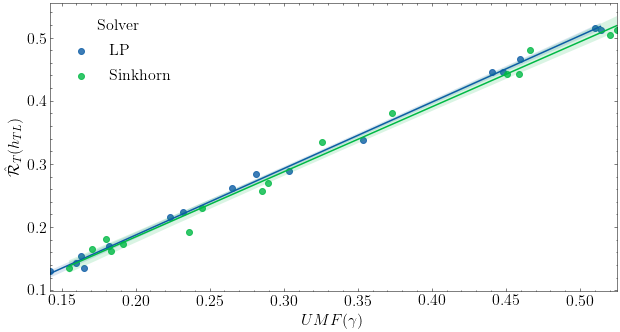

In [6]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.regplot(umf_emd, 1 - np.array(emd_acc), ax=ax, label='LP')
sns.regplot(umf_sink, 1 - np.array(sink_acc), ax=ax, label='Sinkhorn')
ax.set_ylabel('$\hat{\mathcal{R}}_{T}(h_{TL})$')
ax.set_xlabel('$UMF(\gamma)$')
ax.legend(title='Solver')

plt.tight_layout()
plt.savefig('./Figures/Ch6/UMFxRisk.pdf', transparent=True)

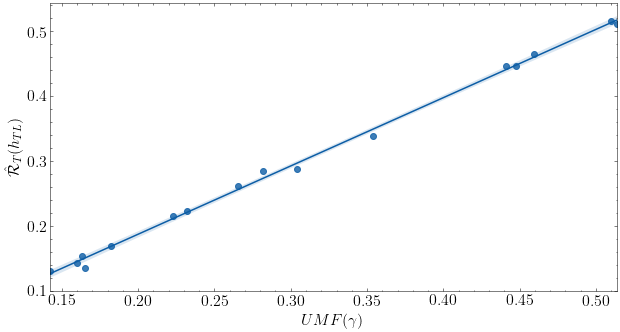

In [7]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.regplot(umf_emd, 1 - np.array(emd_acc), ax=ax)
# sns.regplot(umf_sink, 1 - np.array(sink_acc), ax=ax, label='Sinkhorn')
ax.set_ylabel('$\hat{\mathcal{R}}_{T}(h_{TL})$')
ax.set_xlabel('$UMF(\gamma)$')
# ax.legend(title='Solver')

plt.tight_layout()
plt.savefig('./Figures/Presentation/UMFxRisk.pdf', transparent=True)